In [158]:
%matplotlib qt

import mne
import matplotlib.pyplot as plt
import numpy as np
import enum
import os

In [159]:
TUH_EEG_SEIZURE_CORPUS = "/Users/jannis/Git/tuh-eeg-seizure-detection/data/raw"
OUTPUT = "/dhc/cold/groups/metrics/data/processed"

In [269]:
class Recording:
    path: str
    annotations: mne.Annotations
    
    # seizures are tuples of onset and duration
    seizures: list[(float, float)]
    
    # non-seizures are tuples of onset and duration
    non_seizures: list[(float, float)]
    
    
    def __init__(self, path: str):
        self.path = path
        self.annotations = self._parse_annotation_file()
        
        self.seizures = [(self.annotations.onset[i], self.annotations.duration[i]) for i, x in enumerate(self.annotations.description) if x == "seiz"]
        self.non_seizures = [(self.annotations.onset[i], self.annotations.duration[i]) for i, x in enumerate(self.annotations.description) if x == "bckg"]
        
    
    def _parse_annotation_file(self):
        raw = mne.io.read_raw_edf(self.path)
        annotation_file = self.path.replace(".edf", ".csv_bi")
        raw_annotations: list[str] = []

        with open(annotation_file, "r") as f:
            for line in f:
                raw_annotations.append(line)

        raw_annotations = raw_annotations[6:]

        onset: list[float] = []
        duration: list[float] = []
        description: list[str] = []
        
        for line in raw_annotations:
            parts = line.split(",")
            start = float(parts[1])
            end = float(parts[2])
            label = parts[3]
            
            # prevent overlong annotations
            if end > raw.times[-1]:
                end = raw.times[-1]
            
            onset.append(start)
            duration.append(end - start)
            description.append(label)

        return mne.Annotations(onset, duration, description)
    
    
    def plot(self):
        raw = mne.io.read_raw_edf(self.path)
        raw.set_annotations(self.annotations)
        raw.plot()
        
    
    def resample(self, sampling_rate: int):
        raw = mne.io.read_raw_edf(self.path)
        raw.set_annotations(self.annotations)
        events, event_id = mne.events_from_annotations(raw)
        raw.resample(sampling_rate, events=events)
        
        return raw
 
class Session:
    session_id: str
    recordings: list[Recording]
    configuration: str
    
    def __init__(self, session_id: str, recordings: list[Recording], configuration: str):
        self.session_id = session_id
        self.recordings = recordings
        self.configuration = configuration
        

class Patient:
    patient_id: str
    sessions: list[Session]
    
    def __init__(self, patient_id, sessions: list[Session]):
        self.patient_id = patient_id
        self.sessions = sessions

In [270]:
# Load all patients
patients: list[Patient] = []

# iterate over all data sets in the TUH EEG Seizure Corpus edf folder
for data_set in os.listdir(f"{TUH_EEG_SEIZURE_CORPUS}/edf"):
    data_set_path = os.path.join(TUH_EEG_SEIZURE_CORPUS, 'edf', data_set)
    if not os.path.isdir(data_set_path):
        continue
        
    # iterate over all patients in the data set
    for patient in os.listdir(f"{TUH_EEG_SEIZURE_CORPUS}/edf/{data_set}"):
        patient_path = os.path.join(data_set_path, patient)
        if not os.path.isdir(patient_path):
            continue
            
        sessions = []
        
        # iterate over all sessions in the patient folder
        for session in os.listdir(f"{TUH_EEG_SEIZURE_CORPUS}/edf/{data_set}/{patient}"):
            session_path = os.path.join(patient_path, session)
            if not os.path.isdir(session_path):
                continue


            recordings = []
            
            for configuration in os.listdir(f"{TUH_EEG_SEIZURE_CORPUS}/edf/{data_set}/{patient}/{session}"):
                configuration_path = os.path.join(patient_path, session, configuration)
                if not os.path.isdir(configuration_path):
                    continue
                    
            
                # iterate over all files in the configuration folder
                for file in os.listdir(f"{TUH_EEG_SEIZURE_CORPUS}/edf/{data_set}/{patient}/{session}/{configuration}"):
                    if not file.endswith(".edf"):
                        continue
                    
                    recording = Recording(f"{TUH_EEG_SEIZURE_CORPUS}/edf/{data_set}/{patient}/{session}/{configuration}/{file}")
                    recordings.append(recording)
            
            sessions.append(Session(session, recordings, configuration))
        
        patients.append(Patient(patient, sessions))
        
patients

Extracting EDF parameters from /Users/jannis/Git/tuh-eeg-seizure-detection/data/raw/edf/train/aaaaaizz/s003_2010/02_tcp_le/aaaaaizz_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/jannis/Git/tuh-eeg-seizure-detection/data/raw/edf/train/aaaaaizz/s005_2010/03_tcp_ar_a/aaaaaizz_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/jannis/Git/tuh-eeg-seizure-detection/data/raw/edf/train/aaaaaizz/s004_2010/02_tcp_le/aaaaaizz_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/jannis/Git/tuh-eeg-seizure-detection/data/raw/edf/train/aaaaaizz/s004_2010/02_tcp_le/aaaaaizz_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/jannis/Git/tuh-eeg-seizure-detec

In [271]:
# check if there are duplicate patients across data sets
patient_ids = [patient.patient_id for patient in patients]
duplicates = set([x for x in patient_ids if patient_ids.count(x) > 1])
duplicates

set()

In [272]:
# check if there are patients without seizures
patients_without_seizures: list[Patient] = [] 
patients_with_and_without_seizures: list[Patient] = []
patients_with_seizures: list[Patient] = []

for patient in patients:
    has_non_seizure = False
    has_seizures = False
    
    for session in patient.sessions:
        for recording in session.recordings:
            if len(recording.seizures) > 0:
                has_seizures = True
                
            if len(recording.non_seizures) > 0:
                has_non_seizure = True
            
    if has_seizures and has_non_seizure:
        patients_with_and_without_seizures.append(patient)
    elif has_seizures:
        patients_with_seizures.append(patient)
    else:
        patients_without_seizures.append(patient)
       
len(patients_without_seizures), len(patients_with_seizures), len(patients_with_and_without_seizures)

(388, 55, 232)

In [273]:
def get_windows(window_size: int, patient: Patient):
    non_seizure_windows = 0
    seizure_windows = 0
    
    for session in patient.sessions:
        for recording in session.recordings:
            seizures = recording.seizures
            non_seizures = recording.non_seizures
            
            for seizure in seizures:
                # if seizure duration is smaller than window size, skip
                if seizure[1] < window_size:
                    continue
                    
                # number of windows is floor of seizure duration divided by window size
                seizure_windows += int(seizure[1] // window_size)
            
            for non_seizure in non_seizures:
                # if non-seizure duration is smaller than window size, skip
                if non_seizure[1] < window_size:
                    continue
                    
                # number of windows is floor of non-seizure duration divided by window size
                non_seizure_windows += int(non_seizure[1] // window_size)
                
    return seizure_windows, non_seizure_windows

# We want to extract information per set
-> for each set
-> number of patients, total number of seizure/non-seizure events, total duration of seizure/non-seizure events, total number of seizure/non-seizure windows
-> boxplot of seizures/non-seizures across all patients

In [274]:
def load_set(set_name: str, configurations: list[str]):
    patients: list[Patient] = []
    
    for patient in os.listdir(f"{TUH_EEG_SEIZURE_CORPUS}/edf/{set_name}"):
        if not os.path.isdir(f"{TUH_EEG_SEIZURE_CORPUS}/edf/{set_name}/{patient}"):
            continue

        sessions = []

        for session in os.listdir(f"{TUH_EEG_SEIZURE_CORPUS}/edf/{set_name}/{patient}"):
            if not os.path.isdir(f"{TUH_EEG_SEIZURE_CORPUS}/edf/{set_name}/{patient}/{session}"):
                continue

            recordings = []

            for configuration in os.listdir(f"{TUH_EEG_SEIZURE_CORPUS}/edf/{set_name}/{patient}/{session}"):
                if configuration not in configurations:
                    continue
                    
                if not os.path.isdir(f"{TUH_EEG_SEIZURE_CORPUS}/edf/{set_name}/{patient}/{session}/{configuration}"):
                    continue

                # iterate over all files in the configuration folder
                for file in os.listdir(f"{TUH_EEG_SEIZURE_CORPUS}/edf/{set_name}/{patient}/{session}/{configuration}"):
                    if not file.endswith(".edf"):
                        continue

                    recording = Recording(f"{TUH_EEG_SEIZURE_CORPUS}/edf/{set_name}/{patient}/{session}/{configuration}/{file}")
                    recordings.append(recording)

            if len(recordings) != 0:
                sessions.append(Session(session, recordings, configuration))

        if len(sessions) != 0: 
            patients.append(Patient(patient, sessions))
        
    return patients

In [275]:
configurations = ["01_tcp_ar"]
dev_patients = load_set("dev", configurations)
eval_patients = load_set("eval", configurations)
train_patients = load_set("train", configurations)

Extracting EDF parameters from /Users/jannis/Git/tuh-eeg-seizure-detection/data/raw/edf/dev/aaaaaopm/s003_2013/01_tcp_ar/aaaaaopm_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/jannis/Git/tuh-eeg-seizure-detection/data/raw/edf/dev/aaaaaopm/s003_2013/01_tcp_ar/aaaaaopm_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/jannis/Git/tuh-eeg-seizure-detection/data/raw/edf/dev/aaaaaopm/s003_2013/01_tcp_ar/aaaaaopm_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/jannis/Git/tuh-eeg-seizure-detection/data/raw/edf/dev/aaaaaopm/s003_2013/01_tcp_ar/aaaaaopm_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/jannis/Git/tuh-eeg-seizure-detection/data/

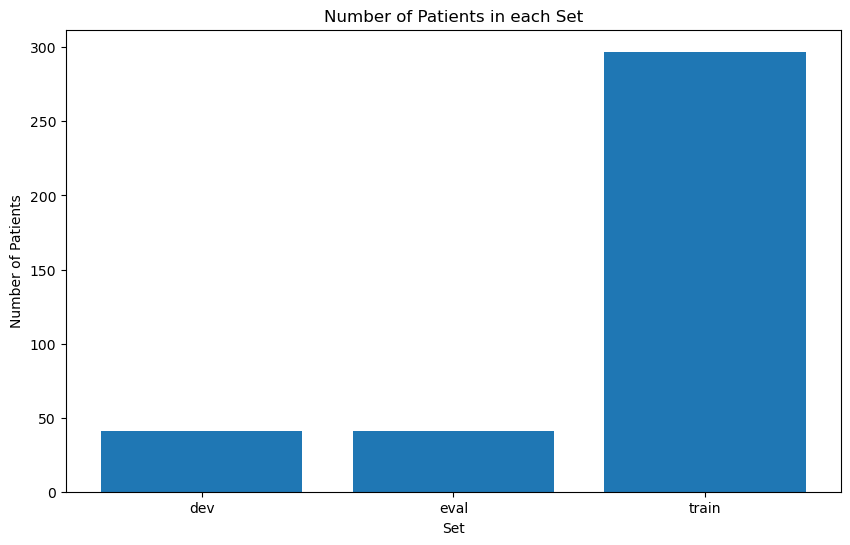

In [277]:
# plot number of patients in each set

num_dev_patients = len(dev_patients)
num_eval_patients = len(eval_patients)
num_train_patients = len(train_patients)

plt.figure(figsize=(10, 6))
plt.bar(['dev', 'eval', 'train'], [num_dev_patients, num_eval_patients, num_train_patients])
plt.title('Number of Patients in each Set')
plt.xlabel('Set')
plt.ylabel('Number of Patients')
%matplotlib inline
plt.show()

In [278]:
def get_total_events(set: list[Patient]):
    total_seizure_events = 0
    total_non_seizure_events = 0
    
    for patient in set:
        for session in patient.sessions:
            for recording in session.recordings:
                total_seizure_events += len(recording.seizures)
                total_non_seizure_events += len(recording.non_seizures)
                
    return total_seizure_events, total_non_seizure_events

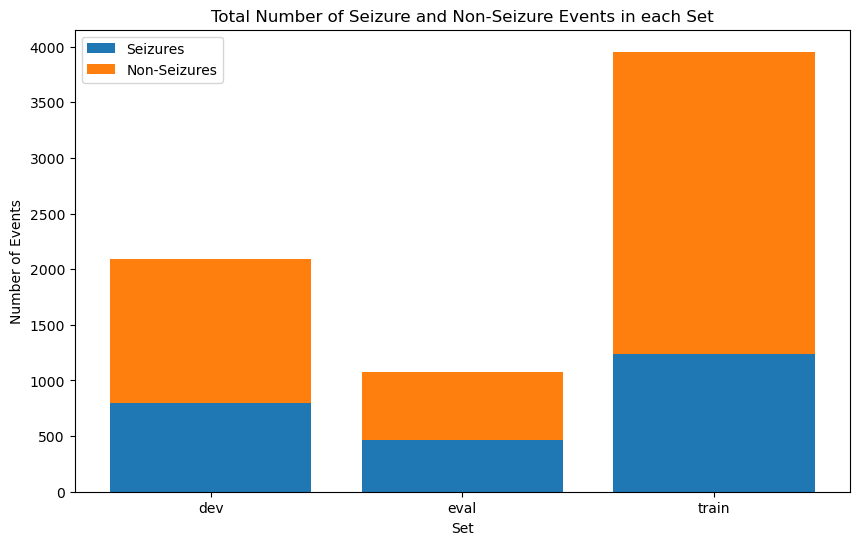

In [279]:
dev_seizures, dev_non_seizures = get_total_events(dev_patients)
eval_seizures, eval_non_seizures = get_total_events(eval_patients)
train_seizures, train_non_seizures = get_total_events(train_patients)

plt.figure(figsize=(10, 6))
plt.bar(['dev', 'eval', 'train'], [dev_seizures, eval_seizures, train_seizures], label='Seizures')
plt.bar(['dev', 'eval', 'train'], [dev_non_seizures, eval_non_seizures, train_non_seizures], label='Non-Seizures', bottom=[dev_seizures, eval_seizures, train_seizures])
plt.title('Total Number of Seizure and Non-Seizure Events in each Set')
plt.xlabel('Set')
plt.ylabel('Number of Events')
plt.legend()
%matplotlib inline
plt.show()


In [280]:
def get_total_duration(set: list[Patient]):
    total_seizure_duration = 0
    total_non_seizure_duration = 0
    
    for patient in set:
        for session in patient.sessions:
            for recording in session.recordings:
                total_seizure_duration += sum([x[1] for x in recording.seizures])
                total_non_seizure_duration += sum([x[1] for x in recording.non_seizures])
                
    return total_seizure_duration, total_non_seizure_duration

In [281]:
dev_seizure_duration, dev_non_seizure_duration = get_total_duration(dev_patients)
eval_seizure_duration, eval_non_seizure_duration = get_total_duration(eval_patients)
train_seizure_duration, train_non_seizure_duration = get_total_duration(train_patients)

print(dev_seizure_duration , dev_non_seizure_duration)
print(eval_seizure_duration, eval_non_seizure_duration)
print(train_seizure_duration, train_non_seizure_duration)

43416.942218749995 103074.26861562525
27246.702600000004 567.5998000000005
95134.97720000002 1423892.1126562601


In [282]:
def get_set_windows(set: list[Patient], window_size: int):
    seizure_windows = 0
    non_seizure_windows = 0
    
    for patient in set:
        seizure_windows_patient, non_seizure_windows_patient = get_windows(window_size, patient)
        seizure_windows += seizure_windows_patient
        non_seizure_windows += non_seizure_windows_patient
                
    return seizure_windows, non_seizure_windows

In [283]:
window_size = 1
dev_seizure_windows, dev_non_seizure_windows = get_set_windows(dev_patients, window_size)
eval_seizure_windows, eval_non_seizure_windows = get_set_windows(eval_patients, window_size)
train_seizure_windows, train_non_seizure_windows = get_set_windows(train_patients, window_size)

print(dev_seizure_windows, dev_non_seizure_windows)
print(eval_seizure_windows, eval_non_seizure_windows)
print(train_seizure_windows, train_non_seizure_windows)

43035 102522
27035 399
94565 1421251


In [284]:
# Example of corrupted session according to previous analysis (aaaaacyi)
dev_patients[0].sessions[2].recordings[0].plot()
print("Test")

Extracting EDF parameters from /Users/jannis/Git/tuh-eeg-seizure-detection/data/raw/edf/dev/aaaaaopm/s009_2014/01_tcp_ar/aaaaaopm_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Using pyopengl with version 3.1.6


/var/folders/8q/rwl87l651pv07ptk0mdv930h0000gn/T/ipykernel_7011/2860980867.py:55: RuntimeWarning: Loading an EDF with mixed sampling frequencies and preload=False will result in edge artifacts. It is recommended to use preload=True.See also https://github.com/mne-tools/mne-python/issues/10635
  raw.plot()
/opt/anaconda3/envs/mne/lib/python3.12/site-packages/mne_qt_browser/_pg_figure.py:2962: RuntimeWarning: Loading an EDF with mixed sampling frequencies and preload=False will result in edge artifacts. It is recommended to use preload=True.See also https://github.com/mne-tools/mne-python/issues/10635
  data_chunk, times_chunk = browser._load_data(start, stop)
/opt/anaconda3/envs/mne/lib/python3.12/site-packages/mne_qt_browser/_pg_figure.py:2962: RuntimeWarning: Loading an EDF with mixed sampling frequencies and preload=False will result in edge artifacts. It is recommended to use preload=True.See also https://github.com/mne-tools/mne-python/issues/10635
  data_chunk, times_chunk = brows

Test


In [212]:
# Example of lost segments
dev_patients[0].sessions[2].recordings[1].plot()

Extracting EDF parameters from /Users/jannis/Git/tuh-eeg-seizure-detection/data/raw/edf/dev/aaaaaopm/s009_2014/01_tcp_ar/aaaaaopm_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Using pyopengl with version 3.1.6


/var/folders/8q/rwl87l651pv07ptk0mdv930h0000gn/T/ipykernel_7011/1224686828.py:50: RuntimeWarning: Loading an EDF with mixed sampling frequencies and preload=False will result in edge artifacts. It is recommended to use preload=True.See also https://github.com/mne-tools/mne-python/issues/10635
  raw.plot()
/opt/anaconda3/envs/mne/lib/python3.12/site-packages/mne_qt_browser/_pg_figure.py:2962: RuntimeWarning: Loading an EDF with mixed sampling frequencies and preload=False will result in edge artifacts. It is recommended to use preload=True.See also https://github.com/mne-tools/mne-python/issues/10635
  data_chunk, times_chunk = browser._load_data(start, stop)
/opt/anaconda3/envs/mne/lib/python3.12/site-packages/mne_qt_browser/_pg_figure.py:2962: RuntimeWarning: Loading an EDF with mixed sampling frequencies and preload=False will result in edge artifacts. It is recommended to use preload=True.See also https://github.com/mne-tools/mne-python/issues/10635
  data_chunk, times_chunk = brows

In [216]:
recording_file = train_patients[0].sessions[0].recordings[0].path
raw = mne.io.read_raw_edf(recording_file, preload=True)
raw.plot()

Extracting EDF parameters from /Users/jannis/Git/tuh-eeg-seizure-detection/data/raw/edf/train/aaaaanoa/s002_2012/01_tcp_ar/aaaaanoa_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...
Using pyopengl with version 3.1.6


In [288]:
# select only specific channels
channels = ["EEG FP1-REF", "EEG FP2-REF", "EEG F7-REF", "EEG F3-REF", "EEG F4-REF", "EEG F8-REF", "EEG T3-REF", "EEG C3-REF", "EEG C4-REF", "EEG T4-REF", "EEG T5-REF", "EEG P3-REF", "EEG P4-REF", "EEG T6-REF", "EEG O1-REF", "EEG O2-REF", "EEG CZ-REF", "EEG A1-REF", "EEG A2-REF", "EEG FZ-REF", "EEG PZ-REF"]
recording = train_patients[0].sessions[0].recordings[0]
raw = mne.io.read_raw_edf(recording.path, preload=True).set_annotations(recording.annotations).pick(channels)
raw.plot()

#ch = mne.pick_channels(raw.info["ch_names"], include=channels)
#combined_raw = mne.channels.combine_channels(raw, dict(eeg=ch), method='mean')
#combined_segmented = mne.make_fixed_length_epochs(combined_raw, duration=1, preload=True)
#combined_segmented.plot()


Extracting EDF parameters from /Users/jannis/Git/tuh-eeg-seizure-detection/data/raw/edf/train/aaaaanoa/s002_2012/01_tcp_ar/aaaaanoa_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 300499  =      0.000 ...  1201.996 secs...
Using pyopengl with version 3.1.6
